<a href="https://colab.research.google.com/github/fatemehabedin2/AIG100/blob/main/LSTM1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf

print("TensorFlow version:", tf.__version__)
gpu_devices = tf.config.list_physical_devices('GPU')
if gpu_devices:
    print("GPU is available for TensorFlow!")
else:
    print("No GPU found for TensorFlow.")

TensorFlow version: 2.18.0
GPU is available for TensorFlow!


In [2]:
import torch

print("PyTorch version:", torch.__version__)
if torch.cuda.is_available():
    print("GPU is available for PyTorch!")
elif torch.mps.is_available():
    print("MPS (Apple Silicon GPU support) is available for PyTorch!")
else:
    print("No GPU found for PyTorch.")

PyTorch version: 2.6.0+cu124
GPU is available for PyTorch!


In [3]:
from google.colab import files
uploaded = files.upload()


Saving aapl_us_2025.csv to aapl_us_2025.csv


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

In [5]:
df = pd.read_csv('aapl_us_2025.csv')
df.shape

(10171, 6)

In [6]:
warnings.filterwarnings("ignore")
pd.set_option("display.max_columns",None)
pd.set_option("display.max_rows",None)

In [7]:
df.head()

,Date,Open,High,Low,Close,Volume
0,1984-09-07,0.099824,0.101049,0.098619,0.099824,9.859472e+07
1,1984-09-10,0.099824,0.100130,0.097424,0.099232,7.652559e+07
2,1984-09-11,0.100130,0.102846,0.100130,0.101049,1.804519e+08
3,1984-09-12,0.101049,0.101641,0.098007,0.098007,1.576401e+08
4,1984-09-13,0.103460,0.103754,0.103460,0.103460,2.455186e+08


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10171 entries, 0 to 10170
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    10171 non-null  object 
 1   Open    10171 non-null  float64
 2   High    10171 non-null  float64
 3   Low     10171 non-null  float64
 4   Close   10171 non-null  float64
 5   Volume  10171 non-null  float64
dtypes: float64(5), object(1)
memory usage: 476.9+ KB


In [9]:
# Data Preprocessing

df['Date'] = pd.to_datetime(df['Date'])
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day

In [10]:
df.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Year', 'Month',
       'Day'],
      dtype='object')

In [11]:
df.Date.max(), df.Date.min()

(Timestamp('2025-01-17 00:00:00'), Timestamp('1984-09-07 00:00:00'))

In [12]:
df.isnull().sum()

,0
Date,0
Open,0
High,0
Low,0
Close,0
Volume,0
Year,0
Month,0
Day,0


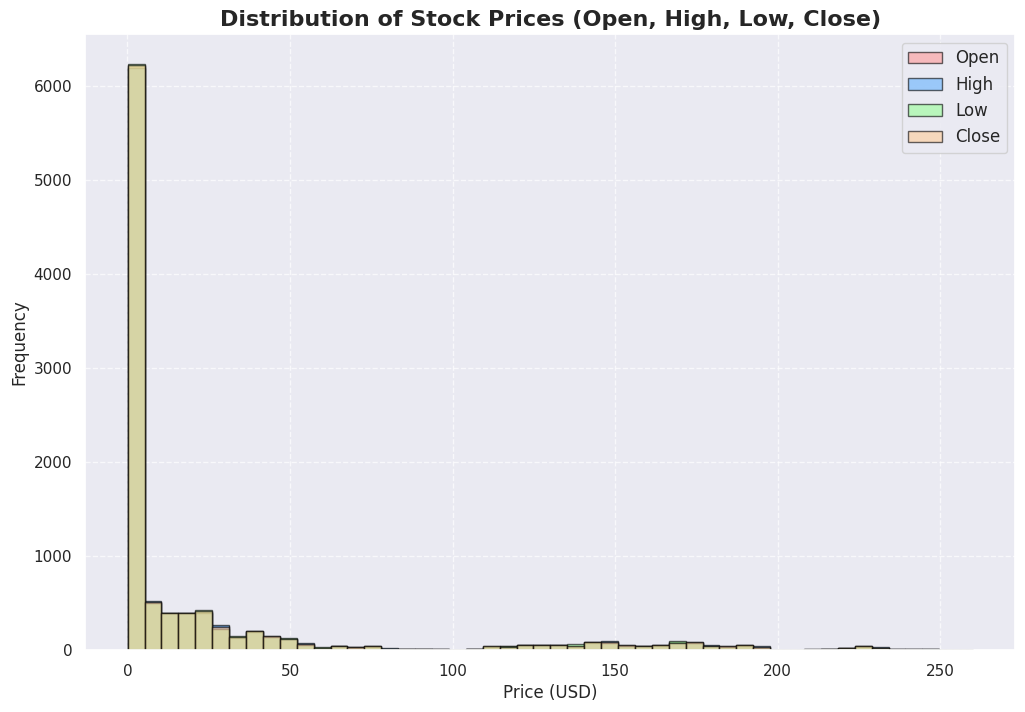

In [13]:
sns.set(style="darkgrid")
colors = ['#FF9999', '#66B2FF', '#99FF99', '#FFCC99']
df[['Open', 'High', 'Low', 'Close']].plot(kind='hist', bins=50, alpha=0.6,color=colors, figsize=(12, 8), edgecolor='black')
plt.title('Distribution of Stock Prices (Open, High, Low, Close)', fontsize=16, weight='bold')
plt.xlabel('Price (USD)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.legend(['Open', 'High', 'Low', 'Close'], loc='upper right', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

In [14]:
sns.set(style="darkgrid")
plt.style.use('seaborn-darkgrid')
plt.figure(figsize=(12, 6))
plt.plot(df['Date'], df['Close'], color='#1f77b4', linewidth=2, label='Closing Price')
plt.title('Closing Price Over Time', fontsize=18, weight='bold', color='#333333')
plt.xlabel('Date', fontsize=14, weight='bold', color='#666666')
plt.ylabel('Close Price (USD)', fontsize=14, weight='bold', color='#666666')
plt.grid(True, linestyle='--', alpha=0.7)
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(10))  # Limit the number of x-axis ticks
plt.gcf().autofmt_xdate()
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

OSError: 'seaborn-darkgrid' is not a valid package style, path of style file, URL of style file, or library style name (library styles are listed in `style.available`)

In [15]:
from sklearn.preprocessing import MinMaxScaler

x = ['Open', 'High', 'Low', 'Volume', 'Year', 'Month', 'Day']
y = 'Close'

# Separate scalers. You can not reuse the same MinMaxScaler instance to scale both X and y. because the second .fit_transform() on y overwrites the scaler trained on X
feature_scaler = MinMaxScaler()
target_scaler = MinMaxScaler()

X_scaled = feature_scaler.fit_transform(df[x])
y_scaled = target_scaler.fit_transform(df[[y]])  #  MinMaxScaler expects a 2D array, even if you're scaling just one feature (like Close).


In [16]:
def create_sequences(X, y, window_size):
    X_seq = []
    y_seq = []
    for i in range(len(X) - window_size):
        X_seq.append(X[i:i+window_size])       # past `window_size` rows
        y_seq.append(y[i+window_size])         # next close price
    return np.array(X_seq), np.array(y_seq)

window_size = 60
X_seq, y_seq = create_sequences(X_scaled, y_scaled, window_size)

In [17]:
print("X_seq shape:", X_seq.shape)
print("y_seq shape:", y_seq.shape)

X_seq shape: (10111, 60, 7)
y_seq shape: (10111, 1)


In [18]:
split_ratio = 0.8  # 80% for training
split_index = int(len(X_seq) * split_ratio)

X_train = X_seq[:split_index]
y_train = y_seq[:split_index]

X_test = X_seq[split_index:]
y_test = y_seq[split_index:]

In [19]:
import torch
from torch.utils.data import TensorDataset, DataLoader

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

In [20]:
# Create TensorDatasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [21]:
import torch.nn as nn

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size=64, num_layers=1):        # input_size is the number of features per time step in your data.
        super(LSTMModel, self).__init__()

        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # LSTM layer
        self.lstm = nn.LSTM(input_size=input_size,
                            hidden_size=hidden_size,
                            num_layers=num_layers,
                            batch_first=True)

        # Fully connectedm (dense) layer (maps from hidden state(last time step’s hidden state, which is a vector of size hidden_size) to 1 output)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):    # This defines the forward pass. how the input flows through the model to produce a prediction.

        # x: [batch_size, sequence_length, input_size]. x is a batch of sequences. [32, 60, 7] → 32 sequences of 60 days, each with 7 features)
        # self.lstm(x) passes x through the LSTM layer.
        # out contains the output at every time step in the sequence
        # The second item (_) is the hidden and cell states (you can ignore unless doing advanced stuff)
        out, _ = self.lstm(x)  # out: [batch_size, sequence_length, hidden_size]

        # Take the output from the LAST time step (extracts time step 59)
        out = out[:, -1, :]  # [batch_size, hidden_size]

        # Pass through final linear layer. This converts the [batch_size, hidden_size] → [batch_size, 1]
        out = self.fc(out)   # [batch_size, 1]
        return out

# Training the LSTM Model
Training Setup: Define model, loss function, and optimizer

In [22]:
X_train.shape

(8088, 60, 7)

In [23]:
import torch.optim as optim

input_size = X_train.shape[2]  # Should be 7
model = LSTMModel(input_size=input_size, hidden_size=64, num_layers=1)

criterion = nn.MSELoss()  # Mean Squared Error (for regression). criterion is just a variable name that typically refers to the loss function. Guides the optimizer on how to update the model weights*9--------

optimizer = optim.Adam(model.parameters(), lr=0.001)  #

An epoch means processing (One full pass through) all sequences, In chunks (mini-batches) of 3 sequences at a time.

Each sequence is still 60 days long, that never changes

In [24]:
num_epochs = 20

for epoch in range(num_epochs):
    model.train()  # Put model in training mode
    epoch_loss = 0

    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()        # Reset gradients. It clears the old gradients from the previous training step and prevents accumulation of the gradients. in standard training loops, you must clear gradients before calculating them again.
        outputs = model(X_batch)     # Forward pass
        loss = criterion(outputs, y_batch)  # Compute loss
        loss.backward()              # Backpropagation, compute gradients
        optimizer.step()             # Update weights

        epoch_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")


Epoch [1/20], Loss: 0.1269
Epoch [2/20], Loss: 0.0009
Epoch [3/20], Loss: 0.0003
Epoch [4/20], Loss: 0.0003
Epoch [5/20], Loss: 0.0003
Epoch [6/20], Loss: 0.0003
Epoch [7/20], Loss: 0.0003
Epoch [8/20], Loss: 0.0002
Epoch [9/20], Loss: 0.0002
Epoch [10/20], Loss: 0.0002
Epoch [11/20], Loss: 0.0003
Epoch [12/20], Loss: 0.0003
Epoch [13/20], Loss: 0.0002
Epoch [14/20], Loss: 0.0002
Epoch [15/20], Loss: 0.0002
Epoch [16/20], Loss: 0.0003
Epoch [17/20], Loss: 0.0003
Epoch [18/20], Loss: 0.0002
Epoch [19/20], Loss: 0.0003
Epoch [20/20], Loss: 0.0002


# Evaluate on test data

In [25]:
model.eval()        # switch to evaluation mode
with torch.no_grad():          # turn off gradient tracking
    test_preds = model(X_test_tensor)
    test_loss = criterion(test_preds, y_test_tensor)
    print(f"Test Loss: {test_loss.item():.4f}")


Test Loss: 0.0008


A loss of 0.0001 in scaled space is very low

It indicates your model's predictions are very close to the actual values on unseen (test) data

Your model is likely generalizing well and not overfitting

# Evaluate in Real Units (e.g., USD)
Since you scaled your target (Close), you should inverse transform the predictions to interpret them in their original scale.

In [26]:
predicted = model(X_test_tensor).detach().numpy()         # Get raw predictions .detach(): Removes the tensor from the computation graph. Prevents gradient tracking
                                                          # .numpy(): Convert to NumPy array.
predicted = target_scaler.inverse_transform(predicted)    # Convert to original scale

actual = target_scaler.inverse_transform(y_test_tensor.numpy())


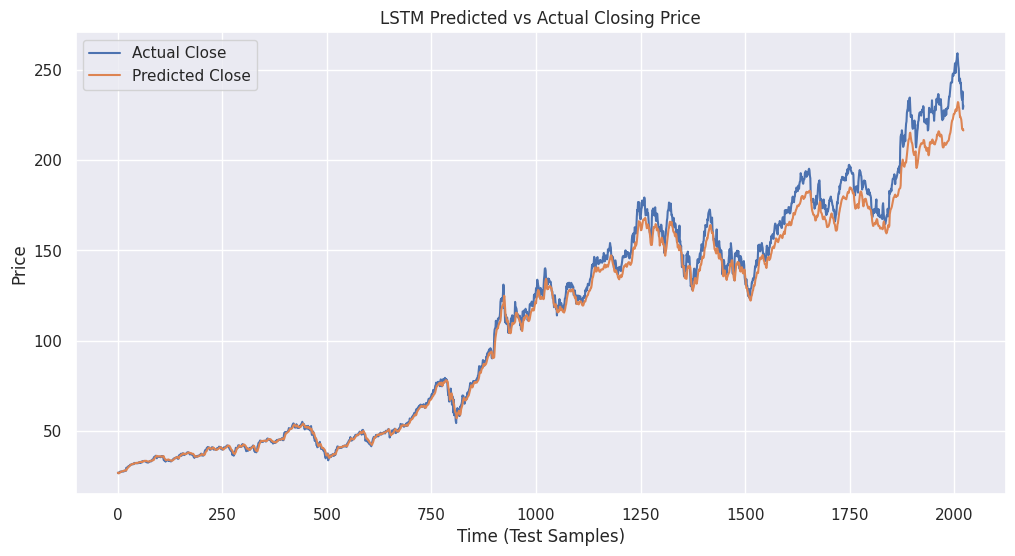

In [27]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(actual, label='Actual Close')
plt.plot(predicted, label='Predicted Close')
plt.title('LSTM Predicted vs Actual Closing Price')
plt.xlabel('Time (Test Samples)')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()


# Save the model:

In [28]:
torch.save(model.state_dict(), 'lstm_model.pth')


#  Load the model :

In [29]:
model = LSTMModel(input_size=7, hidden_size=64, num_layers=1)
model.load_state_dict(torch.load('lstm_model.pth'))
model.eval()  # Set to evaluation mode


LSTMModel(
  (lstm): LSTM(7, 64, batch_first=True)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)